In [20]:
# referrence:  https://keras.io/examples/timeseries/timeseries_weather_forecasting/
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import missingno as msno
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

In [21]:
DATA_DIR = '../../data/data_daily_with_aqi.csv'
raw_df = pd.read_csv(DATA_DIR)

In [22]:
raw_df.tail()

,date,hour,type,北京,天津,石家庄,唐山,秦皇岛,邯郸,保定,张家口,承德,廊坊,沧州,衡水,邢台
14680,2022-04-02,23.0,O3_24h,92.0,126.0,105.0,132.0,141.0,109.0,109.0,99.0,99.0,112.0,128.0,117.0,110.0
14681,2022-04-02,23.0,NO2_24h,20.0,36.0,29.0,26.0,32.0,19.0,31.0,10.0,28.0,24.0,26.0,24.0,23.0
14682,2022-04-02,23.0,SO2_24h,2.0,10.0,5.0,10.0,12.0,8.0,5.0,4.0,5.0,4.0,12.0,7.0,5.0
14683,2022-04-02,23.0,PM2.5_24h,14.0,37.0,24.0,39.0,39.0,38.0,22.0,8.0,18.0,22.0,36.0,34.0,30.0
14684,2022-04-02,23.0,AQI,41.0,78.0,57.0,100.0,94.0,59.0,55.0,25.0,42.0,53.0,94.0,56.0,51.0


### 使用O3 日度数据进行预测，将缺失数据剔除

In [23]:
df = raw_df[raw_df['type']=='AQI'].drop('type',axis=1)
df['label'] = df['北京'].shift(-15)
df =  df.dropna()

In [24]:
df = df.drop(['date','hour'],axis=1)

In [25]:
split_fraction = 0.7
train_split = int(split_fraction * int(df.shape[0]))
step = 1
past = 200
future = 15
learning_rate = 0.0001
batch_size = 256
epochs = 50


In [26]:

def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std


In [27]:
features = df.drop(['label'],axis=1)
features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

In [28]:
start = past + future
end = start + train_split

x_train = train_data.values
y_train = features.iloc[start:end][[1]]

sequence_length = 200

In [29]:

dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    # sampling_rate=step,
    batch_size=batch_size,
)

In [30]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end,:].values
y_val = features.iloc[label_start:][[1]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    # sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_val.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (254, 200, 13)
Target shape: (254, 1)


In [31]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(128)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)
drop_out = keras.layers.Dropout(0.1)(outputs)
model = keras.Model(inputs=inputs, outputs=drop_out)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 13)]         0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               72704     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
 dropout_1 (Dropout)         (None, 1)                 0         
                                                                 
Total params: 72,833
Trainable params: 72,833
Non-trainable params: 0
_________________________________________________________________


In [32]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, 
               modelckpt_callback]
            #    tensorboard_callback],
)

Epoch 1/50


2022-05-21 19:18:59.870553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-21 19:18:59.981909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-21 19:19:00.360088: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 0.8935

2022-05-21 19:19:02.080646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-21 19:19:02.127545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.95414, saving model to model_checkpoint.h5
6/6 [==============================] - 3s 299ms/step - loss: 0.8935 - val_loss: 0.9541
Epoch 2/50
5/6 [========================>.....] - ETA: 0s - loss: 0.9126
Epoch 2: val_loss improved from 0.95414 to 0.92444, saving model to model_checkpoint.h5
6/6 [==============================] - 0s 78ms/step - loss: 0.8749 - val_loss: 0.9244
Epoch 3/50
5/6 [========================>.....] - ETA: 0s - loss: 0.8990
Epoch 3: val_loss improved from 0.92444 to 0.89901, saving model to model_checkpoint.h5
6/6 [==============================] - 0s 75ms/step - loss: 0.8606 - val_loss: 0.8990
Epoch 4/50
6/6 [==============================] - ETA: 0s - loss: 0.8507
Epoch 4: val_loss improved from 0.89901 to 0.87867, saving model to model_checkpoint.h5
6/6 [==============================] - 1s 93ms/step - loss: 0.8507 - val_loss: 0.8787
Epoch 5/50
5/6 [========================>.....] - ETA: 0s - loss: 0.8824
Epoch 5: val_l

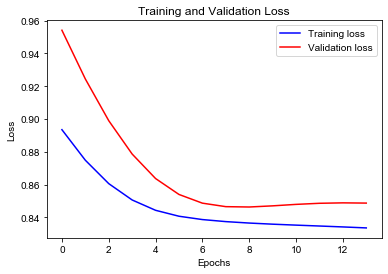

In [33]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

In [34]:

def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return



2022-05-21 19:19:08.834703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-21 19:19:08.871469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 1s 56ms/step


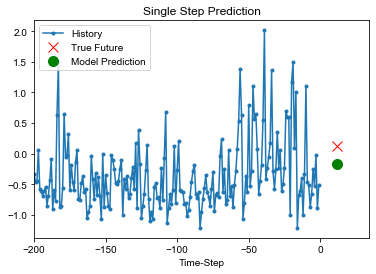

In [35]:
for x, y in dataset_val.take(3):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )

In [36]:
pred = model.predict(dataset_val)

2022-05-21 19:19:09.729903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-21 19:19:09.783367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 384ms/step


Text(0.5, 1.0, 'r2_score:-0.2991')

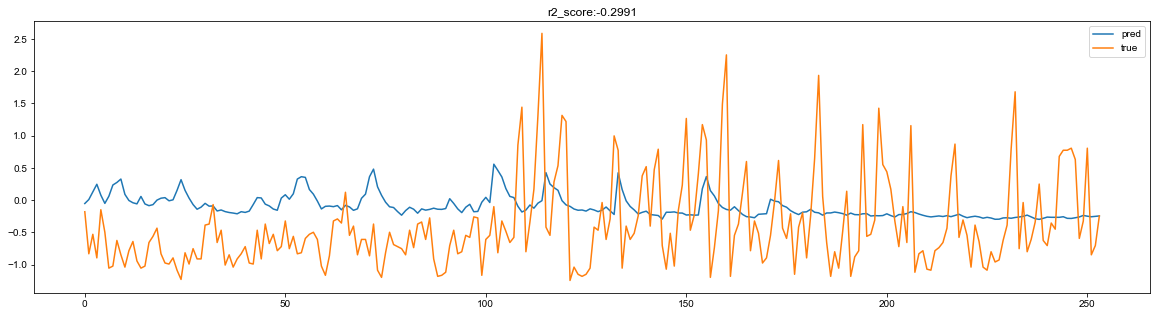

In [37]:
from sklearn.metrics import r2_score
y_pred = pred
y_true = y_val.values.flatten()[-len(y_pred):]
plt.figure(figsize=(20, 5))
plt.plot(y_pred,label = 'pred')
plt.plot(y_true,label='true')
plt.legend()
plt.title('r2_score:{:.4f}'.format(r2_score(y_true,y_pred)))


In [38]:
model.save('./models/lstm_128_dense_1.h5')